# DASCI 212: Group Exercise 2 (LT3)
An Exploratory Data Analysis on COVID-19 Clinical Trials 
<br>
<br> Co, Julie Anne 
<br> Del Valle, Julius Kevin
<br> Tallo, Francis 
<br> Zornosa, Dave

---

In this EDA, we explore a subset of COVID-19 clinical trials, sourced from **[ClinicalTrials.gov](https://www.clinicaltrials.gov/)**. These studies, conducted with human volunteers, aim to evaluate the effects of specific interventions according to the research plan or protocal designed by the investigators. 

---

## I. Data Preparation

Before we begin, we will first import the necessary packages for our analysis. [Code Hidden]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
from pandarallel import pandarallel
import nltk
import pendulum
from collections import Counter
import numpy as np
import warnings
from wordcloud import WordCloud, STOPWORDS
import matplotlib.dates as mdates
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.tag import pos_tag
from helpers import categorical_summ, age_clean, explode_dict, days_between, date_convert, countries, counter_dict, counter_df, yearmonth, year, clean_puncnum, clean_text
pandarallel.initialize()
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Next, we load our COVID dataset into a dataframe. we have a total of 5,783 studies included in this dataset with 27 columns containing information about the study type, status, topics, participants, as well as dates and links.

In [110]:
df = pd.read_csv('covid.csv')
print(df.shape)
shape = len(df)
df.head(3)

(5783, 27)


,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04785898,Diagnostic Performance of the ID Now™ COVID-19...,COVID-IDNow,"Active, not recruiting",No Results Available,Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,Groupe Hospitalier Paris Saint Joseph,All,"18 Years and older (Adult, Older Adult)",Not Applicable,1000.0,Other,Interventional,Allocation: N/A|Intervention Model: Single Gro...,COVID-IDNow,"November 9, 2020","December 22, 2020","April 30, 2021","March 8, 2021",NaN,"March 8, 2021","Groupe Hospitalier Paris Saint-Joseph, Paris, ...",NaN,https://ClinicalTrials.gov/show/NCT04785898
1,2,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,60.0,Other,Interventional,Allocation: Randomized|Intervention Model: Par...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
2,3,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,All,"18 Years and older (Adult, Older Adult)",NaN,500.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482


Our raw data is a mix of structured and unstructured text and 2 numeric columns. Further text pre-processing is necessary to extract relevant information. Among all columns, only Enrollment and Rank are numeric in nature. The rest are object data types which, by inspection, are either taken as text data or as dates. 

In [96]:
pd.DataFrame(df.dtypes).T

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,int64,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object


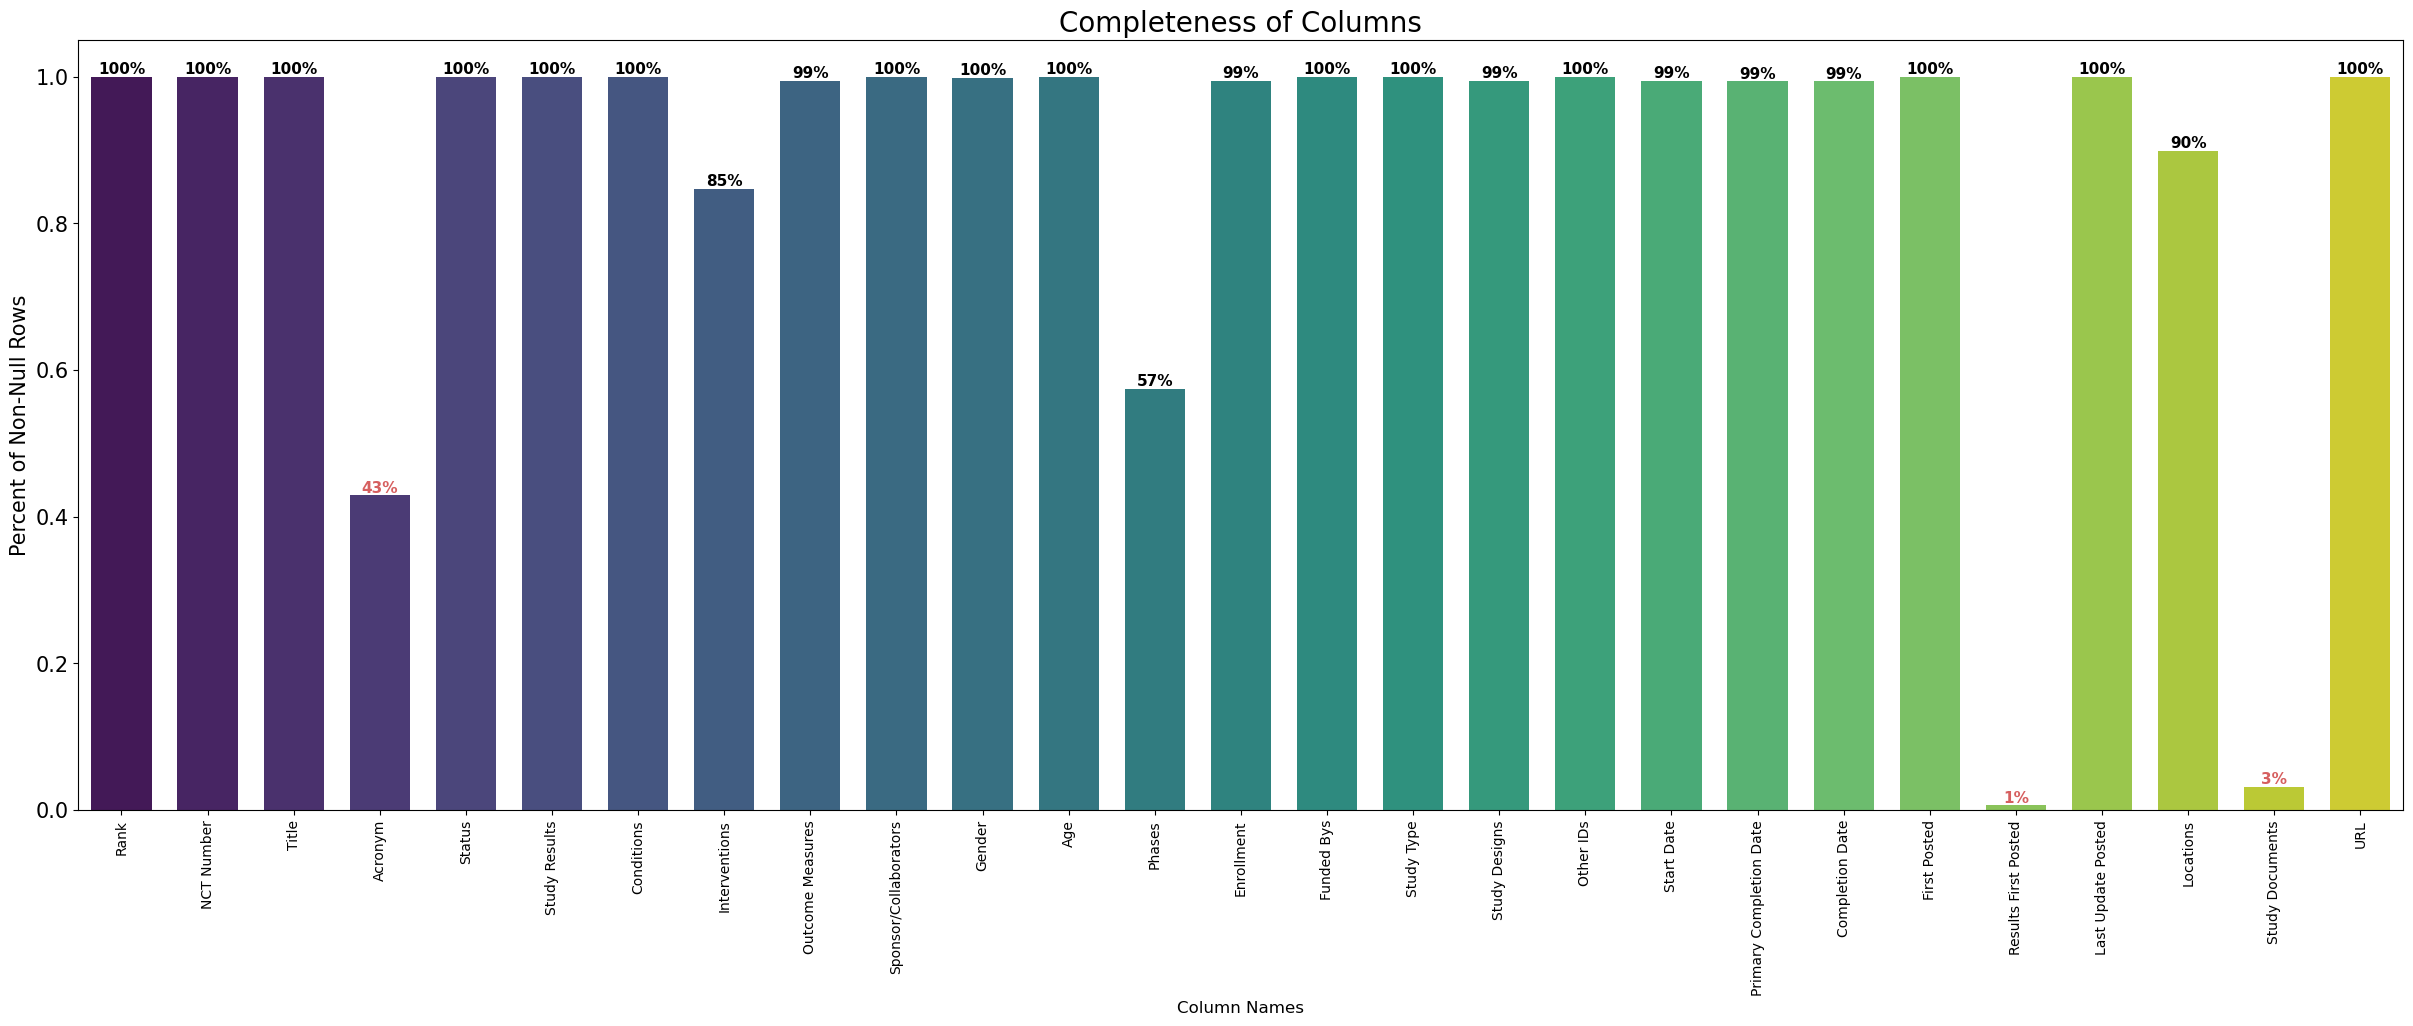

In [111]:
nulls = pd.DataFrame(df.isnull().sum()).reset_index()
nulls.columns = ['Column', 'Count']
nulls['Perc'] = 1 - nulls['Count']/shape

f, ax = plt.subplots(1,1, figsize = (30, 10))

sns.barplot(x="Column", y="Perc", data=nulls,
            label="Percent Nulls", palette = 'viridis', width = 0.7)
plt.xticks(fontsize = 10, rotation = 90)
plt.yticks(fontsize = 15)
ax.set_xlabel('Column Names', fontsize = 12)
plt.title('Completeness of Columns', fontsize = 20)
ax.set_ylabel('Percent of Non-Null Rows', fontsize = 15)

for index, value in enumerate(nulls['Perc']):
    value_str = "{:.0%}".format(value)
    if value < 0.5:
        plt.text(index, value, str(value_str), ha='center', va='bottom', fontsize = 11, color = 'r', fontweight = 'bold')
    else:
        
        plt.text(index, value, str(value_str), ha='center', va='bottom', fontsize = 11,  fontweight = 'bold')
;

Majority of the columns are at least around 90% in terms of completeness of values. However, we have a few columns that have high portion of nulls particularly the <i> Results First Posted, Study Documents, Acronym, and Phases</i>. These columns are rightly nullable as not all studies will have values for them.

---

According to Kaggle, latest update on the Dataset was on April 15, 2021. Hence, we will add a column <i>Partition</i> that corresponds to the snapshot date of the dataset. 

In [112]:
df['Partition'] = pendulum.parse('2021-04-15').to_date_string()

## Data Cleaning and Transformations

[Code Hidden]

Before doing any EDA, we will be cleaning certain categorical columns. This will be done thorugh text transformations and binning certain minor groups together.
<br> <b> Binning Data <br> 
* **Study Type**: Reduced to 3 types due to generalizability. ['Interventional', 'Observational', 'Expanded Access']. <i>See Appendix</i> <br>
* **Funded By (Binned)**: Reduced to categories to 3 types due to generalizability. ['Industry', 'Other', 'NIH, U.S. Fed, Industry, and/or OthersNIH, U.S. Fed, Industry, and/or Others']. <i>See Appendix</i> <br>
* **Age (Group)**: Extracted Age group categories from text. <i>'Child', 'Adult', 'Older Adult', etc <i> <br>
* **Has Results**: Indicator whether study has results (1) or not (0).
* **Posted Results**: Indicator whether study has a Posting Date for results (1) or not (0).
* **Completed**: Indicator whether study has been completed (1) or not (0).

In [113]:
df['Study Type'] = np.where(df['Study Type'].isin(['Interventional', 'Observational']), df['Study Type'], 'Expanded Access')
df['Funded By (Binned)'] = np.where(df['Funded Bys'].isin(['Other', 'Industry']), df['Funded Bys'], 'NIH, U.S. Fed, Industry, and/or Others')
df['Age (Group)'] = df['Age'].parallel_apply(age_clean)
df['Has Results'] = np.where(df['Study Results'] == 'No Results Available', 0, 1)
df['Posted Results'] = np.where(df['Results First Posted'].isna(), 0, 1)
df['Completed'] = np.where(df['Status'] == 'Completed', 1,0)

We will also be standardizing date columns so we can derive time-based variables.
<br> <b>Date Cleaning
* **Partition Date**: Snapshot Date on April 15, 2021 (assumed based on latest update of COVID Data in Kaggle)
* **Start Date, Primary Completion Date, Completion Date, First Posted, Last Update Posted**: Date Format conversion.
* **Study Duration (Primary), Study Duration (Completion)**: Days betweeen the Start Date of the Study vs the declared Primary Completion and Completion dates.
* **Days til Completion**: If study is still open (no Completion Date), days between today and the Completion Date.
* **Days since Update**: Days between the Last Update Posted and today.
* **Days since Started**: Days between the Start Date and today.

In [114]:
df['Start Date'] = df['Start Date'].parallel_apply(date_convert)
df['Primary Completion Date'] = df['Primary Completion Date'].parallel_apply(date_convert)
df['Completion Date'] = df['Completion Date'].parallel_apply(date_convert)
df['First Posted'] = df['First Posted'].parallel_apply(date_convert)
df['Last Update Posted'] = df['Last Update Posted'].parallel_apply(date_convert)
df['Start Date (Year)'] = df['Start Date'].parallel_apply(year)
df['Completion Date (Year)'] = df['Completion Date'].parallel_apply(year)
df['Overdue'] = np.where((df['Completed']==0) & (df['Partition'] > df['Completion Date']), 1, 0)

df['Study Duration (Primary)'] = df.parallel_apply(days_between, args = ('Start Date', 'Primary Completion Date', 0,),axis = 1)
df['Study Duration (Completion)'] = df.parallel_apply(days_between, args = ('Start Date', 'Completion Date', 0,) ,axis = 1)
df['Study Duration (Comp to Prim)'] = df.parallel_apply(days_between, args = ('Primary Completion Date', 'Completion Date', 0,), axis = 1)
df['Days til Completion'] = df.parallel_apply(days_between, args = ('Partition', 'Completion Date', 1,), axis = 1)
df['Days since Update'] = df.parallel_apply(days_between, args = ('Last Update Posted', 'Partition', 0,), axis = 1)
df['Days since Started'] = df.parallel_apply(days_between, args = ('Start Date', 'Partition', 0), axis = 1)


Interventions and Study Designs also have unique format that contains standardized information if extracted. We will store their values in a dictionary for easier access. <br>
**Data Extraction from Stuctured Text**

In [115]:
df['Interventions (Dict)'] = df['Interventions'].parallel_apply(explode_dict)
df['Study Design (Dict)'] = df['Study Designs'].parallel_apply(explode_dict)

We will also extract the countries from the Locations column. We will use the PyCountry library to deternine all the countries invloved in each study. 
<br> <b> Country Extraction

In [116]:
df['Countries'] = df.parallel_apply(countries, axis = 1)
df['No of Countries'] = df['Countries'].parallel_apply(lambda x: len(x))

---
## Quick Stats

By just looking at the summary statistics alone, we see a general view on the **numeric columns**. <br>
* **Enrollment**: On average (median), studies in the dataset involve 170 participants and a maximum of 20,000,000 participants.
* **Has Results**: Only around 0.6% of the studies have available results and have posted them.
* **Completed**: Completion Rate of all studies is at 17.7%.
* **Overdue**: Delayed studies are at 23.8%.
* **Study Duration**: Most studies are declared to take 293 days on average (median).
* **Days til Completion**: Including overdue studies garnering negative values, studies that are not yet completed are due within 110 days on average (median).
* **Days since Started and Updated**: Most studies have been started within 288 days (median) as of snapshot date and have been updated within 122 days.
* **No of Countries**: While there are studies that involve multiple countries, majority is focused on 1 country.

[Unhide df.describe() below for more details]

In [12]:
stats = df.describe().drop('top', axis=0, errors='ignore')
stats.loc['perc_null'] = 1- stats.loc['count']/shape
stats

,Rank,Enrollment,Has Results,Posted Results,Completed,Overdue,Study Duration (Primary),Study Duration (Completion),Study Duration (Comp to Prim),Days til Completion,Days since Update,Days since Started,No of Countries
count,5783.000000,5.749000e+03,5783.000000,5783.000000,5783.000000,5783.000000,5747.000000,5747.000000,5747.000000,4722.000000,5783.000000,5749.000000,5783.000000
mean,2892.000000,1.831949e+04,0.006225,0.006225,0.177244,0.238458,325.264138,418.676005,93.411867,223.726387,148.849559,274.552270,1.161681
std,1669.552635,4.045437e+05,0.078660,0.078660,0.381908,0.426177,571.417097,642.180829,257.666427,637.164751,114.793986,266.733039,1.883581
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-415.000000,1.000000,-261.000000,0.000000
25%,1446.500000,6.000000e+01,0.000000,0.000000,0.000000,0.000000,92.000000,139.000000,0.000000,-16.000000,48.000000,146.000000,1.000000
50%,2892.000000,1.700000e+02,0.000000,0.000000,0.000000,0.000000,211.000000,293.000000,28.000000,108.500000,122.000000,288.000000,1.000000
75%,4337.500000,5.600000e+02,0.000000,0.000000,0.000000,0.000000,365.000000,497.000000,92.000000,320.000000,247.000000,356.000000,1.000000
max,5783.000000,2.000000e+07,1.000000,1.000000,1.000000,1.000000,29119.000000,29119.000000,7305.000000,28749.000000,435.000000,8505.000000,49.000000
perc_null,0.000000,5.879301e-03,0.000000,0.000000,0.000000,0.000000,0.006225,0.006225,0.006225,0.183469,0.000000,0.005879,0.000000


That is all for our data cleaning and quick stats. Now that we are done with the necessary data preparation, we will begin our EDA.

---

## II. Exploratory Data Analysis (COVID CLINICAL STUDIES)



### 1. What are the topics included in the dataset?
A total of 5,783 studies are included in the COVID Clinical Studies Dataset. These were majorly (96%) conducted from 2020 onwards following the onset of COVID 19. The rapid rise in clinical studies peaked a month after COVID-19 was officially a pandemic in March 2020. In fact, April 2020 alone accounts for 15% of the total studies in the dataset.


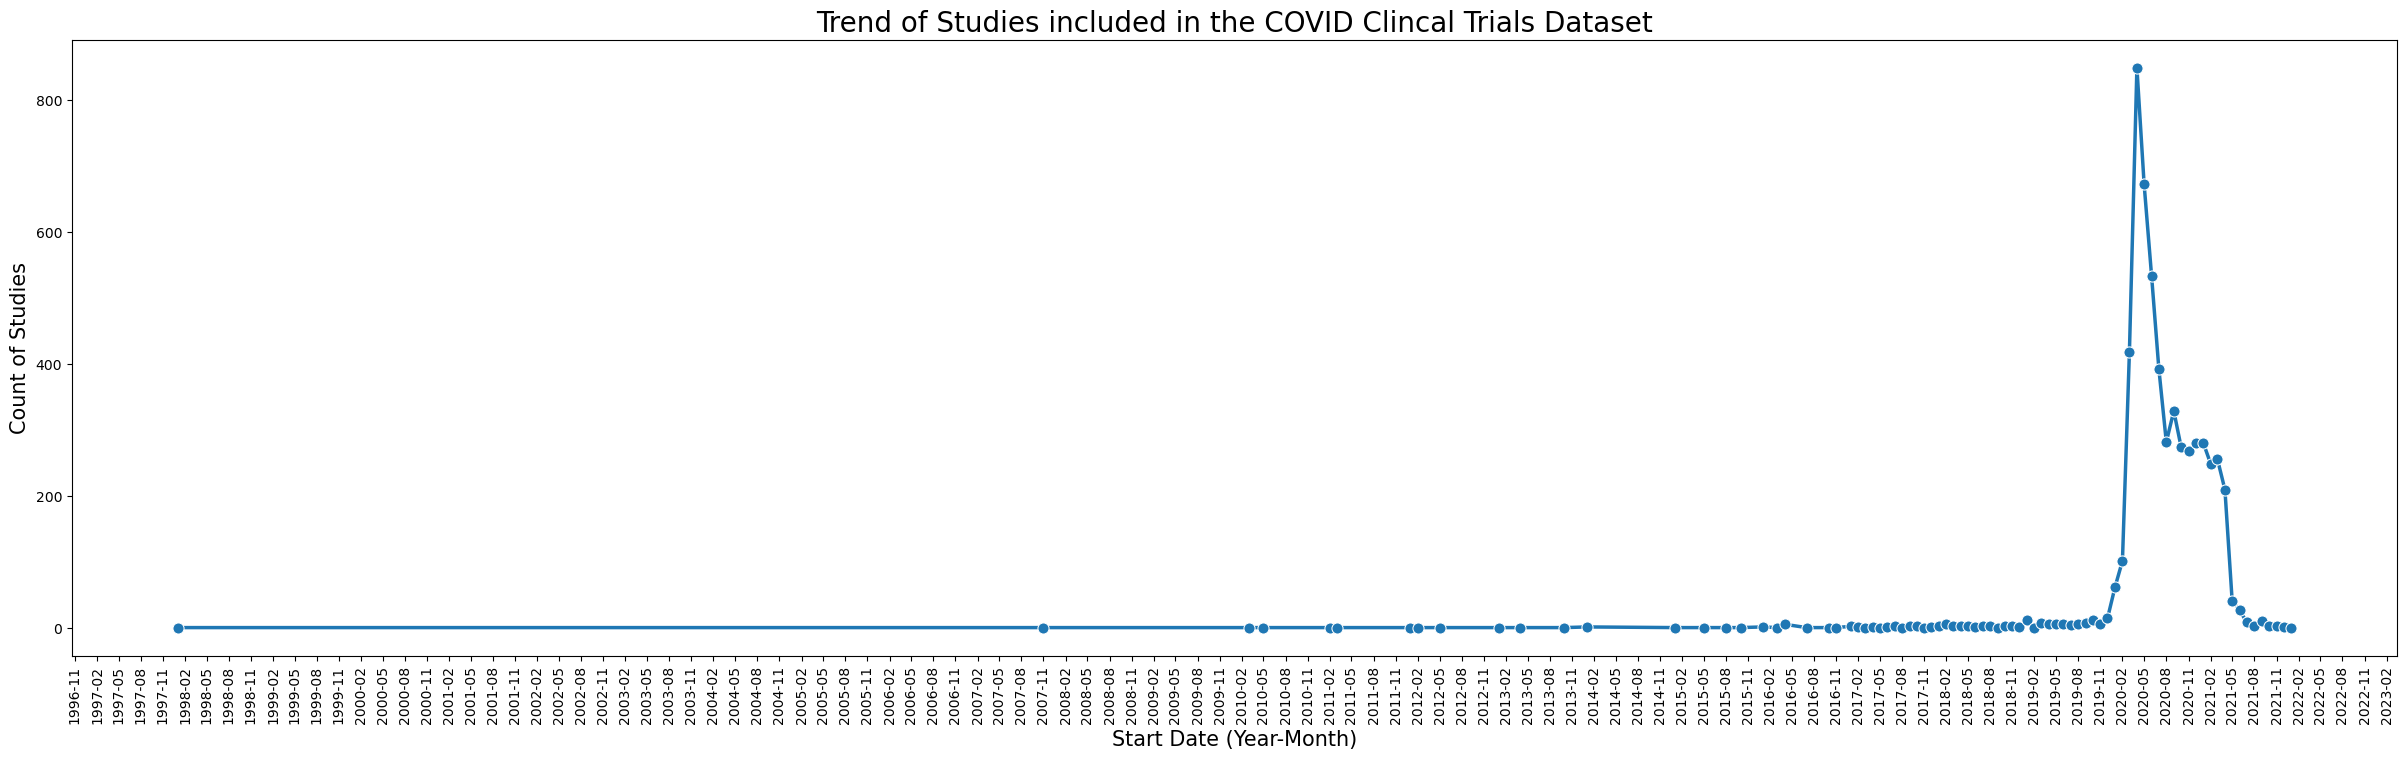

In [13]:
df['Start Date (Yearmon)'] = df['Start Date'].parallel_apply(yearmonth)
year_freq = df.groupby('Start Date (Yearmon)').agg(count = pd.NamedAgg(column = 'NCT Number', aggfunc = 'count')).reset_index()

f, ax = plt.subplots(1,1, figsize = (30, 8))
year_freq['Start Date (Yearmon)'] = pd.to_datetime(year_freq['Start Date (Yearmon)'])
sns.lineplot(data=year_freq, x = 'Start Date (Yearmon)', y = 'count', palette="tab10", linewidth=2.5, marker = 'o', markersize = 8)
plt.xticks(fontsize = 10, rotation = 90)
plt.title('Trend of Studies included in the COVID Clincal Trials Dataset', fontsize = 20)
ax.set_ylabel("Count of Studies", fontsize = 15)
ax.set_xlabel("Start Date (Year-Month)", fontsize = 15)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'));

While COVID-19 is only a recent phenomemon, relevant researches that span as early as 1998 were also included, like the example below. This particularly study is focused on Influenza.

In [90]:
df[df['Start Date'] == '1998-01-01']

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL,Partition,Funded By (Binned),Age (Group),Has Results,Posted Results,Completed,Start Date (Year),Completion Date (Year),Overdue,Study Duration (Primary),Study Duration (Completion),Study Duration (Comp to Prim),Days til Completion,Days since Update,Days since Started,Interventions (Dict),Study Design (Dict),Countries,No of Countries,Start Date (Yearmon),Conditions (Cleaned),Title (Cleaned),Outcome (Cleaned)
5305,5306,NCT04322786,The Use of Angiotensin Converting Enzyme Inhib...,NaN,"Active, not recruiting",No Results Available,"Covid-19, Coronavirus, Angiotensin Converting ...",Drug: ACE inhibitor,Incidence of influenza,"University College, London",All,"18 Years and older (Adult, Older Adult)",NaN,1302508.0,Other,Observational,Observational Model: Case-Control|Time Perspec...,ISAC17_205R,1998-01-01,2016-05-31,2021-03-31,2020-03-26,NaN,2020-11-13,NaN,NaN,https://ClinicalTrials.gov/show/NCT04322786,2021-04-15,Other,"Adult, Older Adult",0,0,0,1998,2021,1,6725.0,8490.0,1765.0,-15.0,153,8505.0,{'Drug': ['ACE inhibitor']},"{'Observational Model': ['Case-Control'], 'Tim...",[],0,1998-01,covid coronavirus angiotensin health comorbidi...,use angiotensin,incidence influenza


Other than that, 3% (~200) of the studies included in this dataset antedates the beginning of COVID-19. 

In [14]:
def keep_nn(x):
    
    text = [word for word, pos in pos_tag(word_tokenize(x)) if pos in ['NN', 'NNP']]
    return ' '.join(text)
                                        
df['Conditions (Cleaned)'] = df['Conditions'].parallel_apply(clean_puncnum).parallel_apply(clean_text).parallel_apply(keep_nn)
df['Title (Cleaned)'] = df['Title'].parallel_apply(clean_puncnum).parallel_apply(clean_text).parallel_apply(keep_nn)
df['Outcome (Cleaned)'] = df['Outcome Measures'].parallel_apply(lambda x: str(x)).parallel_apply(clean_puncnum).parallel_apply(clean_text).parallel_apply(keep_nn)

**Related Studies prior to COVID-19 in Dec 2019**
<br> These past studies are related to diseases such as breast cancer, respiratory conditions, chron disease, multiple sclerosis, sars cov, etc. Other more behavioral and lifestyle-related risks were also included such as anxiety, obesity, stress disorder, etc.

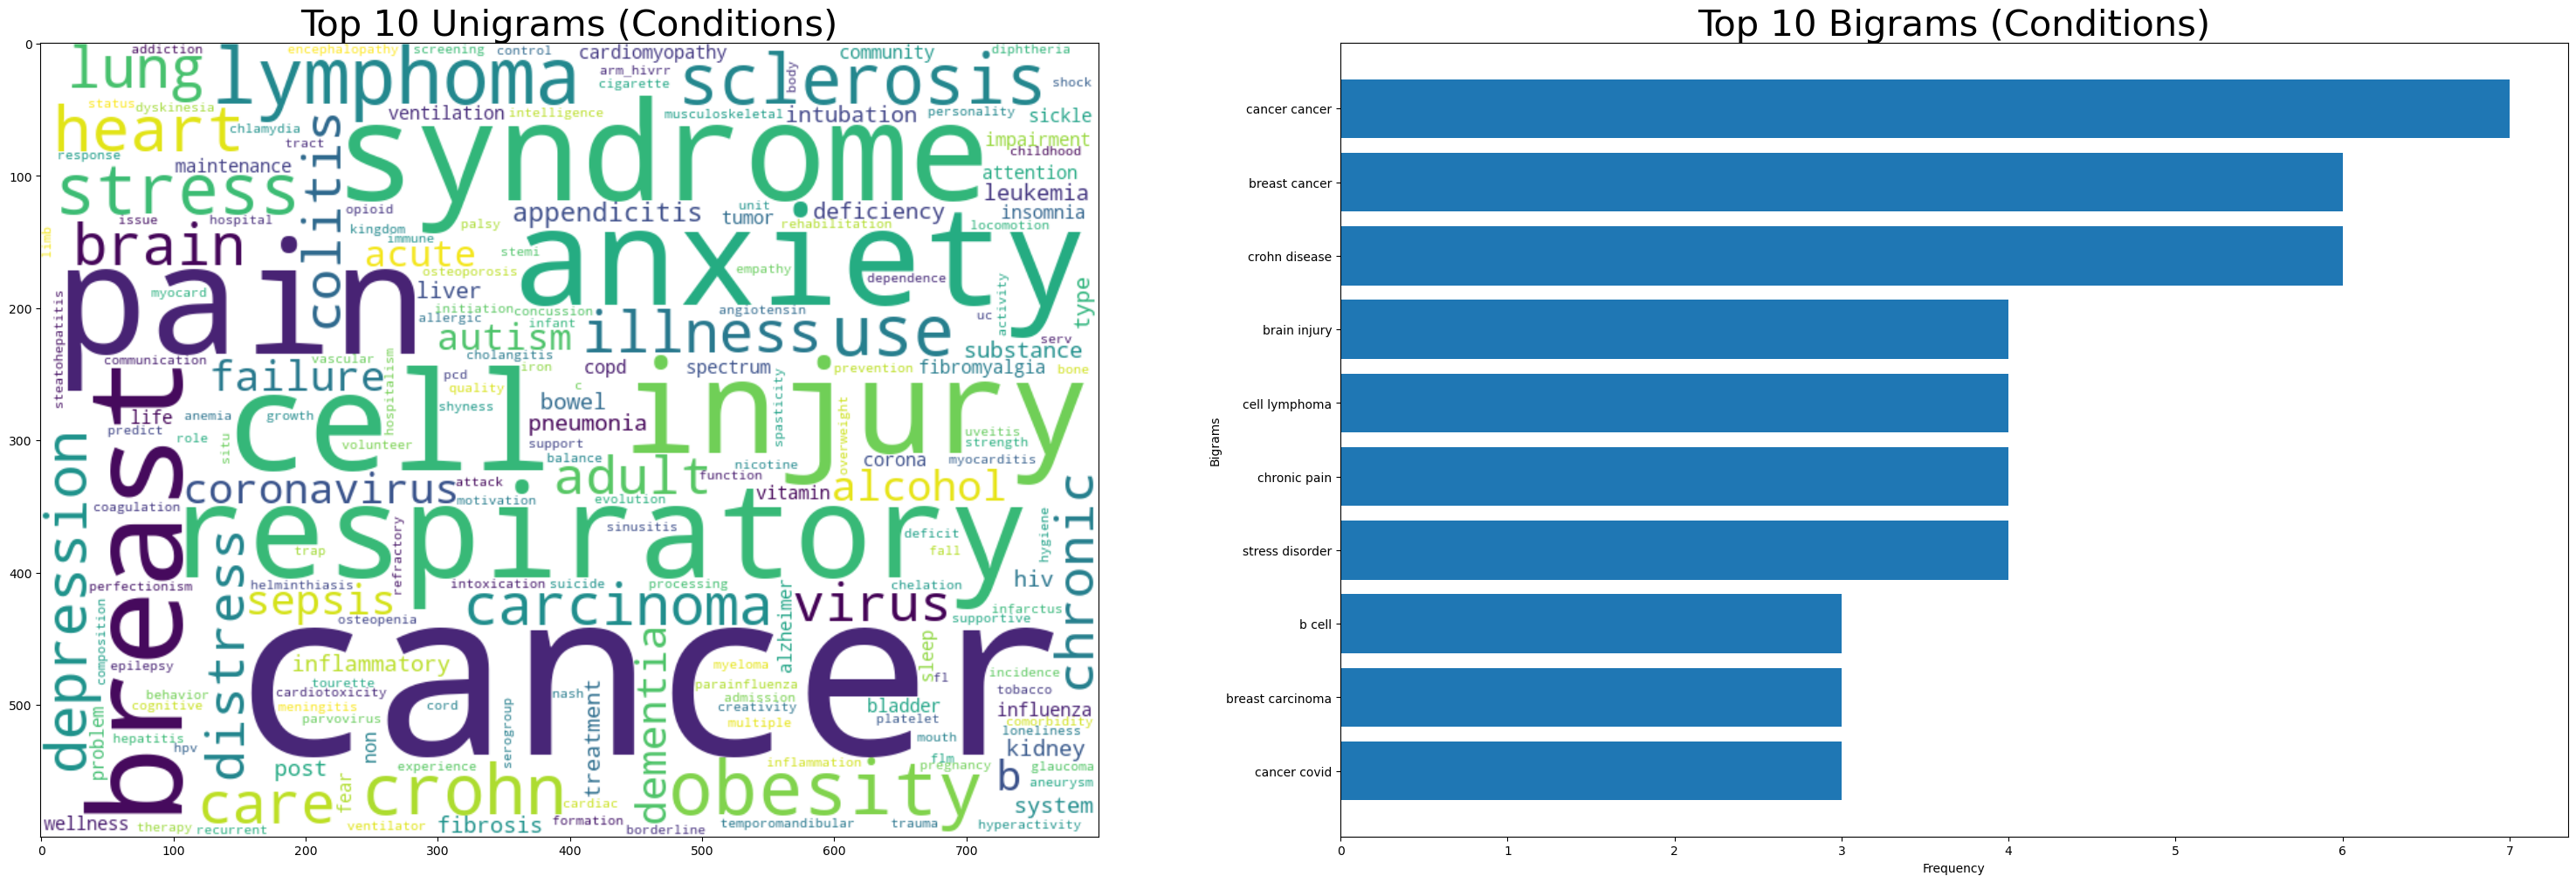

In [55]:
f, [ax1, ax2] = plt.subplots(1,2, figsize = (30, 10), constrained_layout = True)

stopwords = list(STOPWORDS) 
corpus = df[df['Start Date']<'2019-12']['Conditions (Cleaned)'].str.lower().tolist()
corpus = ' '.join(corpus)
stopwords += ['study', 'disease', 'infection', 'disorder', 'health', 'covid']
wordcloud = WordCloud(width = 800, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10, collocations = False).generate(corpus)

ax1.imshow(wordcloud, interpolation = 'bilinear')
ax1.set_title('Top 10 Unigrams (Conditions)', fontsize = 30)
;

words = word_tokenize(corpus)

finder = BigramCollocationFinder.from_words(words)

# Get top 10 most frequent bigrams
top_10_bigrams = finder.nbest(BigramAssocMeasures.raw_freq, 10)


# Compute frequencies of top 10 bigrams
bigram_freq = {}
for bigram in top_10_bigrams:
    bigram_freq[' '.join(bigram)] = finder.ngram_fd[bigram]

# Create horizontal bar plot
ax2.barh(list(bigram_freq.keys()), list(bigram_freq.values()))
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Bigrams')
ax2.set_title('Top 10 Bigrams (Conditions)', fontsize = 30)
plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency on top
plt.show()



---
**Topics in COVID Clinical Studies Dataset**

In general, COVID-19 clinical studies have a wide array of topics and perspectives. Here below is an example of Topic Clusters derived using a simple Latent Dirichlet Allocation model applied on the column (Conditions). Basing on the top 10 keywords in each topic is suggestive of 3 possible main clusters:

* **Topic 1:** COVID and complicating conditions
* **Topic 2:** COVID and respiratory-related risks and repercussions
* **Topic 3:** COVID in relation to quality of life and mental health factors

<i> NOTE: No thorough preprocessing and validation was done for this step. This is only the least number of clusters with explainable differences in top keywords. This is for demonstration purposes.</i>

In [16]:
import gensim
from gensim.utils import simple_preprocess

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['covid', 'cov', 'diseases', 'disease', 'disorder'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


In [34]:
data = df['Conditions (Cleaned)'].values.tolist()
words = list(sent_to_words(data))
words = remove_stopwords(words)


import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(words)
# Create Corpus
texts = words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

from pprint import pprint
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

The LDA model clustered the studies into 3. These are the important keywords in each topics. 
<br> <i> Note that indices of topic in model output does not follow the same order in the Distance Map below. </i>

In [35]:
print("Topic Clusters")
pprint(lda_model.print_topics())

Topic Clusters
[(0,
  '0.114*"infection" + 0.043*"syndrome" + 0.043*"respiratory" + '
  '0.042*"pneumonia" + 0.027*"cancer" + 0.020*"coronavirus" + 0.017*"anxiety" '
  '+ 0.015*"distress" + 0.014*"injury" + 0.012*"kidney"'),
 (1,
  '0.078*"infection" + 0.056*"virus" + 0.056*"respiratory" + 0.042*"corona" + '
  '0.029*"syndrome" + 0.024*"acute" + 0.022*"failure" + 0.016*"pneumonia" + '
  '0.016*"distress" + 0.015*"lung"'),
 (2,
  '0.129*"coronavirus" + 0.076*"infection" + 0.029*"stress" + 0.028*"health" + '
  '0.028*"anxiety" + 0.027*"respiratory" + 0.019*"pneumonia" + '
  '0.017*"depression" + 0.014*"failure" + 0.010*"syndrome"')]


In [108]:
print("Topic Clusters")
pprint(lda_model.print_topics())

Topic Clusters
[(0,
  '0.055*"infection" + 0.043*"anxiety" + 0.037*"stress" + 0.027*"respiratory" '
  '+ 0.024*"depression" + 0.020*"virus" + 0.018*"syndrome" + 0.018*"illness" + '
  '0.017*"distress" + 0.016*"corona"'),
 (1,
  '0.160*"infection" + 0.124*"coronavirus" + 0.036*"virus" + 0.032*"cancer" + '
  '0.029*"respiratory" + 0.025*"corona" + 0.021*"pneumonia" + 0.013*"syndrome" '
  '+ 0.011*"kidney" + 0.008*"arthritis"'),
 (2,
  '0.072*"respiratory" + 0.051*"syndrome" + 0.042*"pneumonia" + '
  '0.030*"infection" + 0.030*"acute" + 0.028*"failure" + 0.026*"health" + '
  '0.022*"distress" + 0.016*"coronavirus" + 0.016*"care"')]


In [105]:
# Initialize an empty list to store the topic labels
topic_labels = []

# Iterate through each document in the corpus
for doc in corpus:
    # Get the list of topics and their corresponding probabilities for the current document
    topics = lda_model.get_document_topics(doc, minimum_probability=0.1)  # Adjust the threshold as needed
    
    # Sort the topics by probability and get the most probable topic
    most_probable_topic = max(topics, key=lambda x: x[1])
    
    # Get the topic label (you may need to manually assign labels based on the topic keywords)
    topic_label = f"Topic {most_probable_topic[0]}"
    
    # Append the topic label to the list
    topic_labels.append(topic_label)

df['Topic Labels'] = topic_labels

In [ ]:
topic_freq = df.groupby('Topic Labels').agg(count = pd.NamedAgg(column = 'NCT Number', aggfunc = 'count')).reset_index()
#Need to manually change coz the graph did not follow model's index
#topic_freq['Topic Labels'] = ['Topic 2', 'Topic 1', 'Topic 3']
topic_freq['perc'] = topic_freq['count']/shape
topic_freq.sort_values(by = 'Topic Labels')

We use gensim's pyLDAvis to visualize our topic model. Each circle represents a topic cluster. The Chart on the right dynamically showcases the top tokens in each cluster. 

In [100]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.105866 -0.009867       1        1  37.077428
2      0.063389 -0.069995       2        1  34.043030
0      0.042477  0.079862       3        1  28.879542, topic_info=            Term        Freq       Total Category  logprob  loglift
11   coronavirus  510.000000  510.000000  Default  30.0000  30.0000
0      infection  793.000000  793.000000  Default  29.0000  29.0000
12       anxiety  151.000000  151.000000  Default  28.0000  28.0000
112       stress  141.000000  141.000000  Default  27.0000  27.0000
65         acute  116.000000  116.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
55       failure   24.914605  136.547294   Topic3  -4.6775  -0.4592
35     pneumonia   27.795329  232.569424   Topic3  -4.5681  -0.8823
11   coronavirus   33.947600  510.160671   Topic3  -4.3681  -1.4679
53          care   17.862209   75.772522   Topic3  -5.0102  -0.2030
4         cancer   16.677821  141.577595   Topic3  -5.0789  -0.8967

[219 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
522       1  0.113816  activity
522       2  0.227633  activity
522       3  0.796715  activity
65        1  0.094476     acute
65        2  0.807342     acute
...     ...       ...       ...
30        2  0.194173     virus
30        3  0.243845     virus
60        1  0.208878  wellness
60        2  0.678855  wellness
60        3  0.104439  wellness

[362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### 2. What types of studies are included in the dataset?


Around 58% of the trials in the dataset are interventional studies, 42% are observational studies, and the rest are expanded access.
* **Interventional:** Participants are grouped based on the interventions/treatment received vs no intervention. These aims to evaluate the effects of the intervention on either biomedical or health-related outcomes. The assignments are determined by the research design.
* **Observational:** Participants are identified as belonging to a astudy groups and assessed for biomedical or health outcomes. They may receive interventions but they are not assigned/grouped to specific interventions.
* **Expanded Access:** Also called compassionate use, these are for patients with serious conditions who are given access to to medical products that may have not yet been approved by the US FDA.

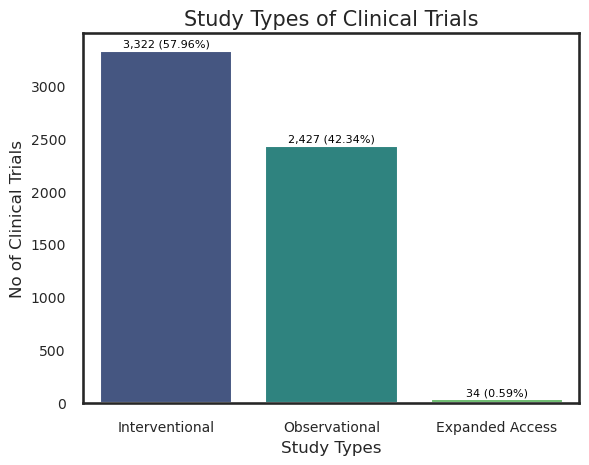

In [234]:
type_freq = pd.DataFrame(df.groupby('Study Type').agg(count = pd.NamedAgg(column = 'NCT Number', aggfunc = 'count'))).sort_values(by = 'count', ascending = False).reset_index()
type_freq['perc_total'] = type_freq['count']/sum(type_freq['count'])

type_freq['count'] = type_freq['count'].astype(int)

f, ax = plt.subplots()

# Plot the total crashes
#sns.set_color_codes("pastel")
sns.barplot(x="Study Type", y="count", data=type_freq,
            label="Total", palette = 'viridis')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
ax.set_xlabel('Study Types', fontsize = 12)
plt.title('Study Types of Clinical Trials', fontsize = 15)
ax.set_ylabel('No of Clinical Trials', fontsize = 12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f} ({p.get_height()/5732:,.2%})', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points');

#### Interventional Studies
The top type of intervention given in amongst the interventional studiees is Drug -- namely placebo drugs, hydroxychloroquine, and remdesivir. Standard of Care came in third.

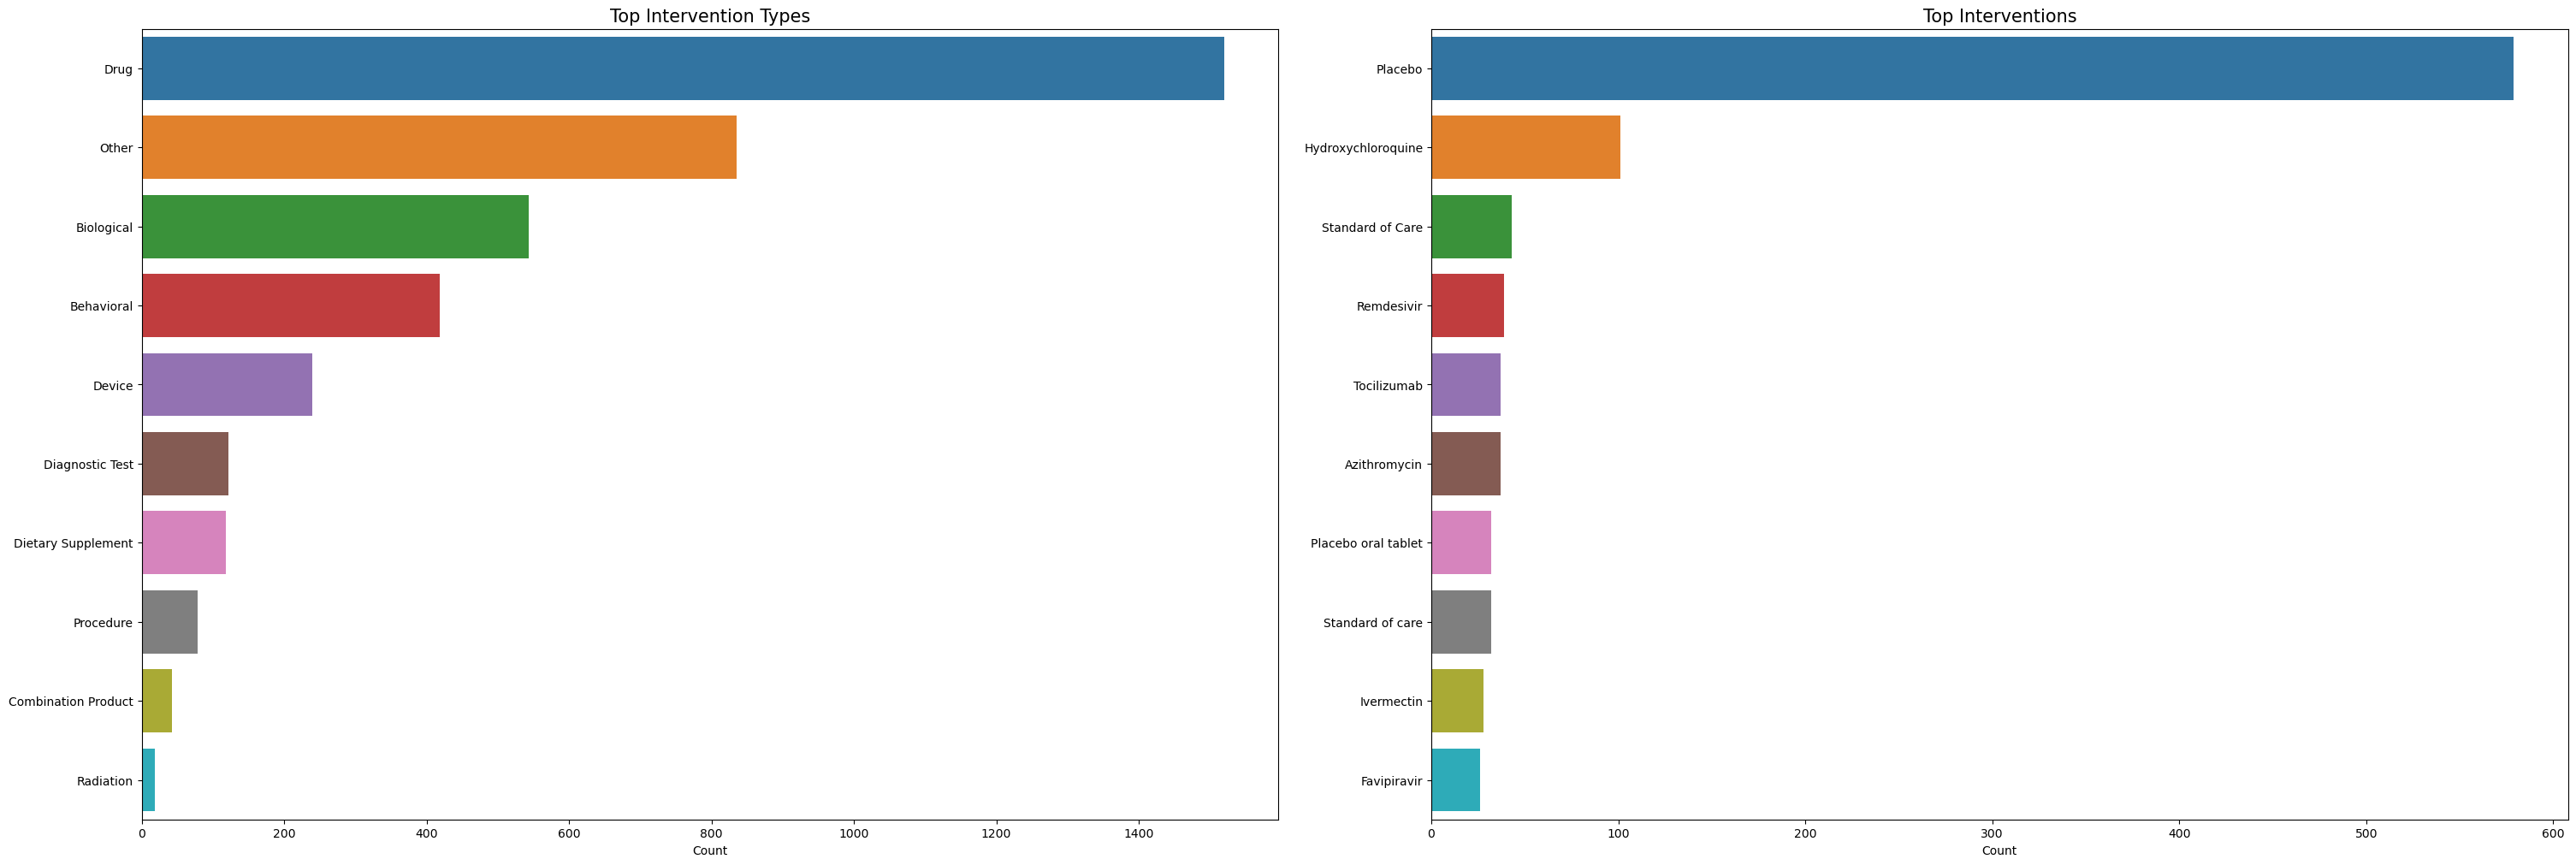

In [91]:
int_type = counter_dict(df[df['Study Type'] == 'Interventional']['Interventions (Dict)'], 'Intervention Type')
int_type['perc_total'] = int_type['Count']/len(df)
int_type.head(10)

int_spec = counter_dict(df[df['Study Type'] == 'Interventional']['Interventions (Dict)'], 'Intervention', keys = False)
int_spec['perc_total'] = int_spec['Count']/len(df)
int_spec.head(10)

f, (ax1, ax2)= plt.subplots(1,2, figsize = (30, 10), constrained_layout  = True)

#ns.lineplot(x, y, ax=ax2, color='red')
#ax2.set_title('Seaborn Plot')

#total_colors = []


sns.barplot(x="Count", y="Intervention Type", data=int_type.head(10),
            label="Top Intervention Types", ax = ax1);
ax1.set_title('Top Intervention Types', fontsize = 15);
ax1.set_ylabel(None)

sns.barplot(x="Count", y="Intervention", data=int_spec.head(10),
             ax = ax2);
ax2.set_title('Top Interventions', fontsize = 15);
ax2.set_ylabel(None)
;

#### Observational Studies
On the other hand, observational studies focused more on monitoring the participant's quality of life, change of results vs baseline, mental health, infection rate, mortality, etc in relation to COVID.

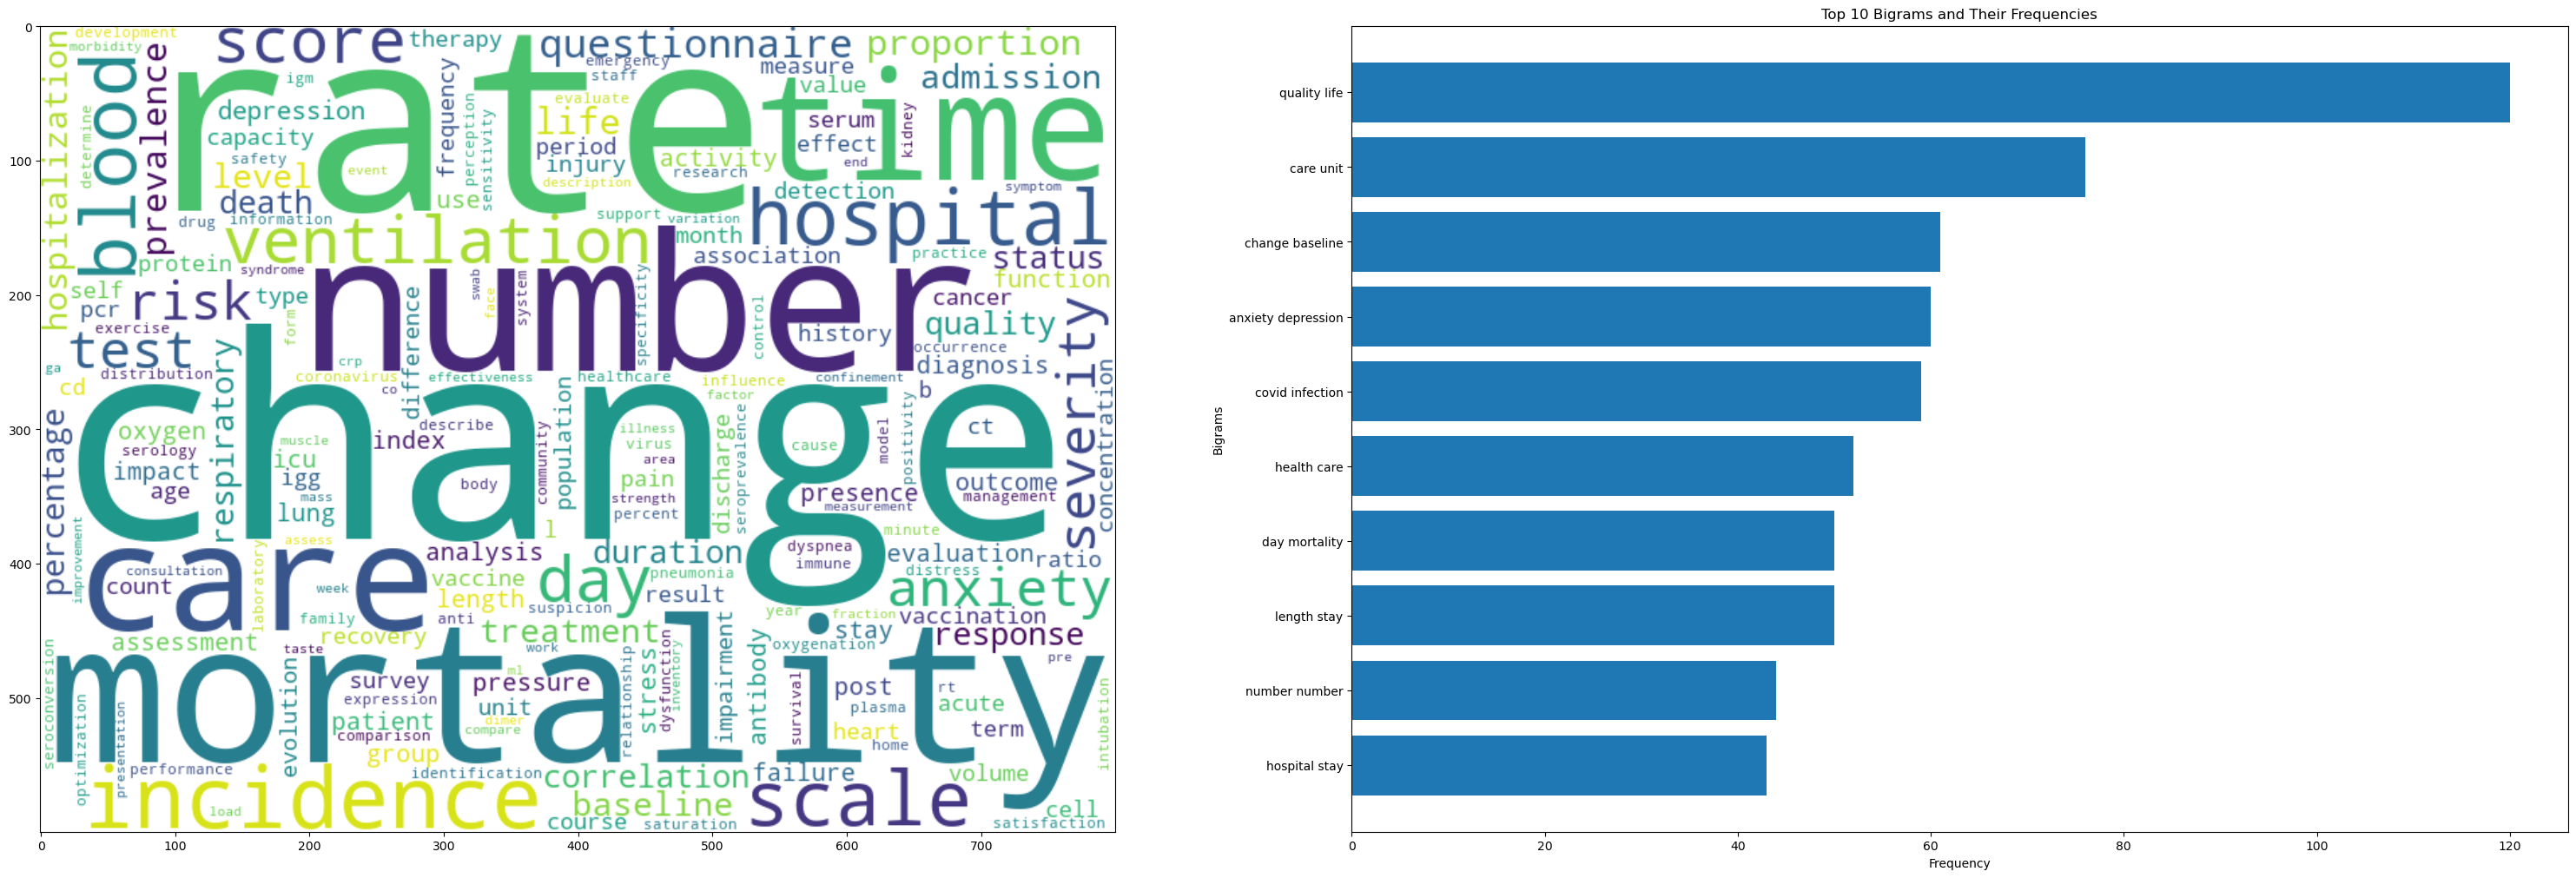

In [46]:
f, [ax1, ax2] = plt.subplots(1,2, figsize = (30, 10), constrained_layout = True)

stopwords = list(STOPWORDS) 
corpus = df[df['Study Type']=='Observational']['Outcome (Cleaned)'].str.lower().tolist()
corpus = ' '.join(corpus)
stopwords += ['study', 'disease', 'infection', 'disorder', 'health', 'covid']
wordcloud = WordCloud(width = 800, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10, collocations = False).generate(corpus)

ax1.imshow(wordcloud, interpolation = 'bilinear');

words = word_tokenize(corpus)

finder = BigramCollocationFinder.from_words(words)

# Get top 10 most frequent bigrams
top_10_bigrams = finder.nbest(BigramAssocMeasures.raw_freq, 10)

# Compute frequencies of top 10 bigrams
bigram_freq = {}
for bigram in top_10_bigrams:
    bigram_freq[' '.join(bigram)] = finder.ngram_fd[bigram]

# Create horizontal bar plot
ax2.barh(list(bigram_freq.keys()), list(bigram_freq.values()))
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Bigrams')
ax2.set_title('Top 10 Bigrams and Their Frequencies')
plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency on top
plt.show()



---

### 3. Who are the study participants?

More than 80% of the studies focused on the adult and older adults demographic. This is because of the cited higher risk of severe symptoms and death amongst older adults. Children, on the other hand are supposed to have milder symptoms and even asymptomatic which makes them the less ideal demographic for COVID studies.

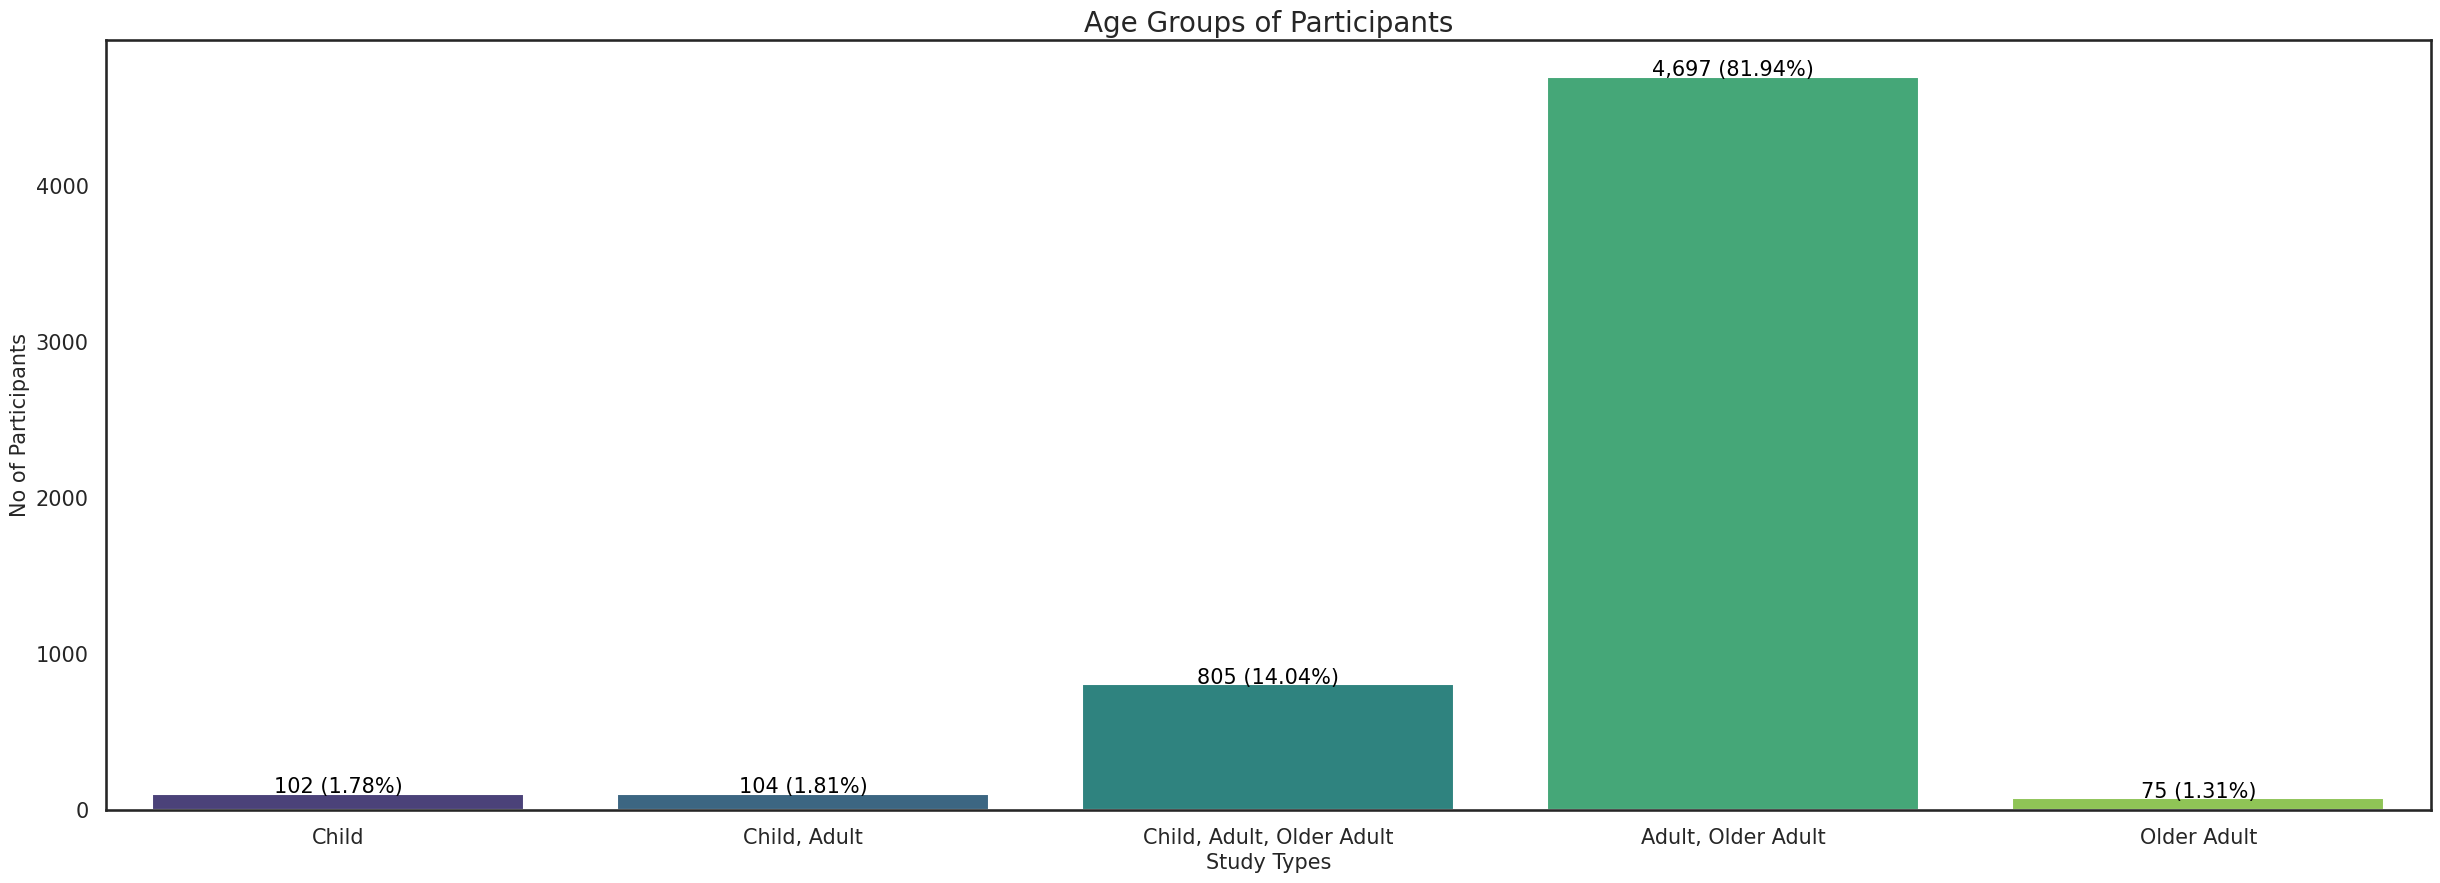

In [279]:
df['Age Group v2'] = np.where(df['Age (Group)']=='Adult', 'Adult, Older Adult', df['Age (Group)'])
age_freq = pd.DataFrame(df.groupby('Age Group v2')['NCT Number'].count().sort_values(ascending = False)).reset_index()
age_freq.columns = ['Age Group', 'count']
age_freq['perc_total'] = age_freq['count']/len(df)
age_freq = age_freq.loc[[3,2,1,0,4]]

f, ax = plt.subplots(1,1, figsize = (30, 10))

sns.barplot(x="Age Group", y="count", data=age_freq,
            label="Total", palette = 'viridis')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel('Study Types', fontsize = 15)
plt.title('Age Groups of Participants', fontsize = 20)
ax.set_ylabel('No of Participants', fontsize = 15)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f} ({p.get_height()/5732:,.2%})', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=15, color='black', xytext=(0, 5), 
                textcoords='offset points');

### Geographic Location
The study was administered in 144 countries, with the United States of America and France being the top countries. Most of the studies focused on the American and European demographic. Only less than 5% of the studies were administered to the Asian countries.

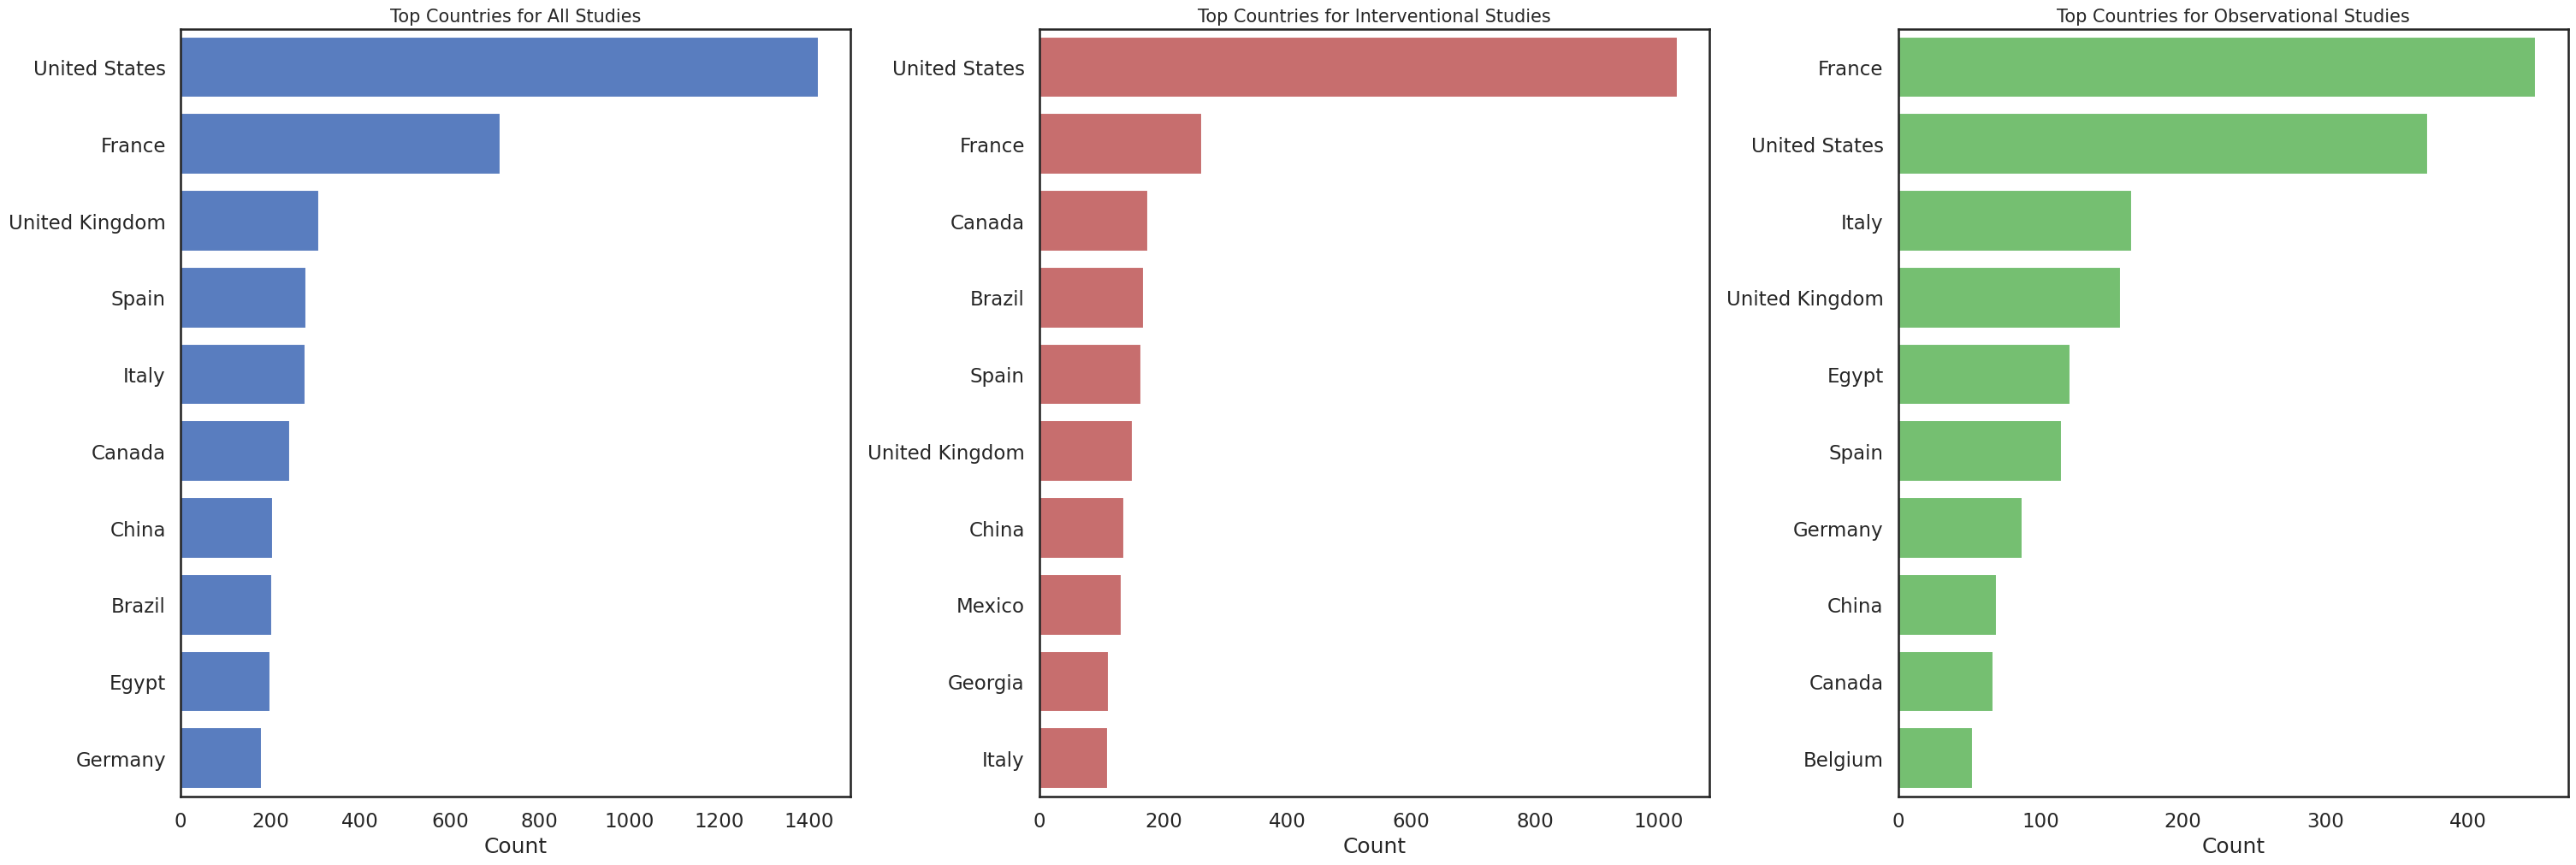

In [250]:
#Dataset for Total Studies
total_countries = counter_df(df['Countries'], 'Countries')
total_countries['perc_total'] = total_countries['Count']/len(df)

#Dataset for Interventional Studies
int_countries = counter_df(df[df['Study Type'] == 'Interventional']['Countries'], 'Countries')
int_countries['perc_total'] = int_countries['Count']/len(df[df['Study Type'] == 'Interventional'])


#Dataset for Observational Studies
obs_countries = counter_df(df[df['Study Type'] == 'Observational']['Countries'], 'Countries')
obs_countries['perc_total'] = obs_countries['Count']/len(df[df['Study Type'] == 'Observational'])


f, (ax1, ax2, ax3)= plt.subplots(1,3, figsize = (30, 10), constrained_layout  = True)

#ns.lineplot(x, y, ax=ax2, color='red')
#ax2.set_title('Seaborn Plot')

#total_colors = []


sns.barplot(x="Count", y="Countries", data=total_countries.head(10),
            label="Top Countries for All Studies", ax = ax1, color = 'b');
ax1.set_title('Top Countries for All Studies', fontsize = 15);
ax1.set_ylabel(None)

sns.barplot(x="Count", y="Countries", data=int_countries.head(10),
             ax = ax2, color = 'r');
ax2.set_title('Top Countries for Interventional Studies', fontsize = 15);
ax2.set_ylabel(None)

sns.barplot(x="Count", y="Countries", data=obs_countries.head(10),
             ax = ax3, color = 'g');
ax3.set_title('Top Countries for Observational Studies', fontsize = 15);

ax3.set_ylabel(None);

---

### 4. What are the status of the studies?

Out of all the ~6,000 studies, only **around 18% of the studies have been completed** -- meaning that they have ended normally and participants are no longer being treated or examined. However, only 33 studies out of the 1,025 (3%) completed studies have posted their results. This is an arguably low publish rate.

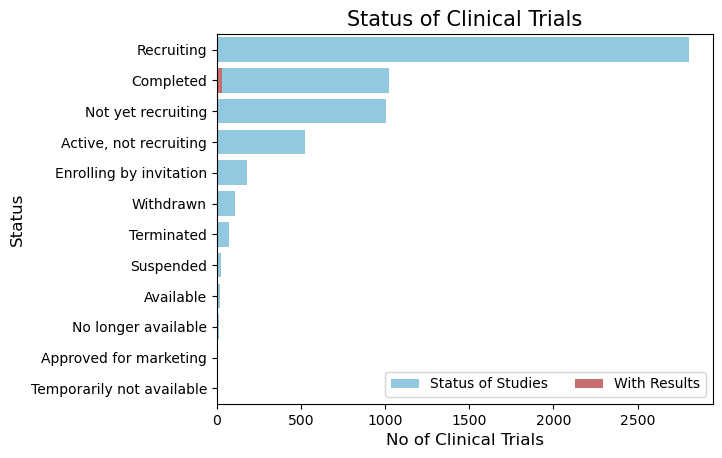

In [59]:
status_freq = pd.DataFrame(df.groupby('Status').agg(count = pd.NamedAgg(column = 'NCT Number', aggfunc = 'count')
                                                    ,results = pd.NamedAgg(column = 'Has Results', aggfunc = 'sum'))).sort_values(by = 'count', ascending = False).reset_index()
status_freq['perc_total'] = status_freq['count']/sum(status_freq['count'])
status_freq

# Initialize the matplotlib figure
f, ax= plt.subplots()

# Plot the total crashes
sns.barplot(x="count", y="Status", data=status_freq,
            label="Status of Studies", color  = 'skyblue')

sns.set_color_codes("muted")
sns.barplot(x="results", y="Status", data=status_freq,
            label="With Results", color="r")

ax.legend(ncol=2, loc="lower right", frameon=True, fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
ax.set_xlabel('No of Clinical Trials', fontsize = 12)
plt.title('Status of Clinical Trials', fontsize = 15)
ax.set_ylabel('Status', fontsize = 12);

In [100]:
percent_status_freq

,1. Not Applicable,2. Early Phase 1,3. Phase 1,4. Phase 1|Phase,5. Phase 2,6. Phase 2|Phase 3,7. Phase 3,8. Phase 4
Status,,,,,,,,
"Active, not recruiting",0.316239,0.019943,0.125356,0.074074,0.230769,0.042735,0.168091,0.022792
Completed,0.491304,0.006522,0.082609,0.036957,0.169565,0.043478,0.121739,0.047826
Enrolling by invitation,0.635294,0.047059,0.011765,0.035294,0.117647,0.011765,0.070588,0.070588
Not yet recruiting,0.431193,0.007645,0.064220,0.070336,0.174312,0.070336,0.136086,0.045872
Recruiting,0.409235,0.013915,0.061986,0.058191,0.216951,0.064516,0.123972,0.051233
Suspended,0.080000,0.080000,0.000000,0.080000,0.160000,0.160000,0.360000,0.080000
Terminated,0.185714,0.000000,0.057143,0.028571,0.357143,0.085714,0.214286,0.071429
Withdrawn,0.197917,0.031250,0.072917,0.041667,0.312500,0.062500,0.208333,0.072917


Phase Trials are not applicable to most of the studies. 
* **Recruiting**: Except studies with no phases, a bulk of the recruiting happens in Phase 2.
* **Completed**: Around 50% of the completed status have no phase trials. 17% of them studies have reached Phase 2 which is the biggest chunk of phase trials amongst all studies and status. Only 5% of the completed studies reached Phase 4.
* **Terminated and Suspended**: Roughly 50% of theses studies reached Phase 2 and/or Phase 3 before terminated and/or suspended. 

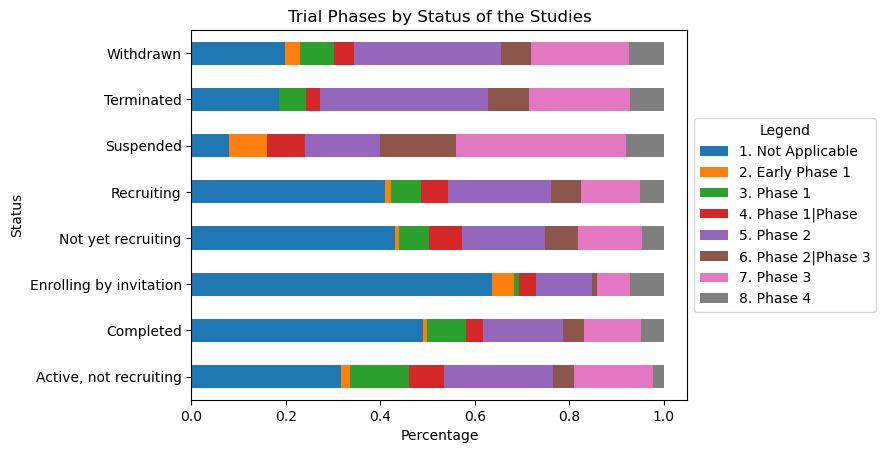

In [94]:
# Assuming you have a DataFrame called status_freq
status_freq = pd.pivot_table(df, index = 'Status', columns = 'Phases', values=['NCT Number'], aggfunc = 'count', fill_value = 0)

# Calculate percentages
percent_status_freq = status_freq.div(status_freq.sum(axis=1), axis=0)
percent_status_freq.columns = ['2. Early Phase 1', '1. Not Applicable', '3. Phase 1', '4. Phase 1|Phase ', '5. Phase 2'
                              ,'6. Phase 2|Phase 3', '7. Phase 3', '8. Phase 4']

percent_status_freq = percent_status_freq[[ '1. Not Applicable',  '2. Early Phase 1', '3. Phase 1', '4. Phase 1|Phase ', '5. Phase 2'
                              ,'6. Phase 2|Phase 3', '7. Phase 3', '8. Phase 4']]
# Create figure and axis
f, ax = plt.subplots()

# Create the horizontal bar plot inside the ax object
percent_status_freq.plot(kind='barh', stacked=True, ax=ax)

# Add legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

# Add labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Status')
ax.set_title('Trial Phases by Status of the Studies')

# Show the plot
plt.show()


As of April 15, 2021, 96% of the ongoing studies are past their declared Completion Date. Despite that, they have at least posted updates in the website within the last 4 months.

In [121]:
df['Overdue'] = np.where((df['Status'] != 'Completed') & (df['Completion Date'] < pendulum.now().to_date_string()),1,0)
recruit = df[df['Status'].isin(['Recruiting', 'Not yet recruiting', 'Active, not recruiting', 'Enrolling by invitation'])].groupby('Status').agg(count = pd.NamedAgg(column = 'NCT Number', aggfunc = 'count')
                                ,overdue = pd.NamedAgg(column = 'Overdue', aggfunc = 'sum')
                                ,avg_days_since_upd = pd.NamedAgg(column = 'Days since Update', aggfunc = 'median')).sort_values(by = 'count', ascending = False)
recruit['avg_months_since_upd'] = recruit['avg_days_since_upd']/30
recruit['perc_overdue'] = recruit['overdue']/recruit['count']
output = recruit[['count', 'overdue', 'perc_overdue', 'avg_months_since_upd']]
output.columns  = ['Total', 'Overdue', '%Overdue', 'Months since Update (Avg)']
output['%Overdue'] = output['%Overdue'].parallel_apply(lambda x: x*100).round(2).map('{:.2f}%'.format)
output['Months since Update (Avg)'] = output['Months since Update (Avg)'].round(0)
output

,Total,Overdue,%Overdue,Months since Update (Avg)
Status,,,,
Recruiting,2805,2677,95.44%,4.0
Not yet recruiting,1004,966,96.22%,5.0
"Active, not recruiting",526,513,97.53%,3.0
Enrolling by invitation,181,173,95.58%,4.0


## III. Recommendations
The Exploratory Data Analysis has provided us with a quick glimpse on the content and nature of the studies. As with any EDA exercise, the more we dig deep on the data, deeper questions begin to be asked which needs a more deep-dive analysis on the data. Hence, these are our recommended stories/perspectives to dive into for analysis:

* Why is the publish rate low? Are there truly lack of results or is it more of a lack of updates on the website?
* Why are there few-to-none studies on the Asia-Pacific regions, considering Asia is the birthplace of COVID?
* Will there be any studies related to vaccine interventions in the dataset?
* What happened to the studies that did not move to Phase 4?